In [38]:
!pip install candlestick

from candlestick.patterns.candlestick_finder import CandlestickFinder


class BearishEngulfing(CandlestickFinder):
    def __init__(self, target=None):
        super().__init__(self.get_class_name(), 2, target=target)

    def logic(self, idx):
        candle = self.data.iloc[idx]
        prev_candle = self.data.iloc[idx + 1 * self.multi_coeff]

        close = candle[self.close_column]
        open = candle[self.open_column]
        high = candle[self.high_column]
        low = candle[self.low_column]

        prev_close = prev_candle[self.close_column]
        prev_open = prev_candle[self.open_column]
        prev_high = prev_candle[self.high_column]
        prev_low = prev_candle[self.low_column]
        
        return (open >= prev_close > prev_open and
                open > close and
                prev_open >= close and 
                open - close > prev_close - prev_open)

ModuleNotFoundError: No module named 'candlestick'

In [12]:
import pandas as pd
import talib
import numpy as np
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.signal import argrelmax
from scipy.signal import argrelmin
#from mpl_finance import candlestick2_ohlc
#from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import yfinance as yf
data=yf.Ticker("INFY")
df=data.history(period="2y")
df

#List all columns in CSV file
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

#Set index values (0, 1, 2...) as a Date Value
df = df.set_index(df.date)

df = df.drop_duplicates(keep=False)

#Convert Date column to a list
df['date'] = pd.to_datetime(df['date']).tolist()

#Only select last 200 values ['start':'end']
df = df.iloc[:200]

#Make copies of each column not to corrupt data
open = df.open.copy()
high = df.high.copy()
low = df.low.copy()
close = df.close.copy()
volume = df.volume.copy()
prices = df.close.copy()

#TA-LIB Doji Scanner
doji = talib.CDLDOJI(open, high, low, close)
doji_star = talib.CDLDRAGONFLYDOJI(open, high, low, close)


#Find peaks of Doji candle prices and use 'Order' to reduce sensitivity
#Returns a Index value of a valid Doji candle
# doji_idx = argrelmax(doji.values, order=1)
# doji = close[doji_idx[0]]
#
# doji_idx_star = argrelmax(doji_star.values, order=1)
# doji_star = close[doji_idx_star[0]]


#Create a Doji Column, replace Doji points with with an candle close price
df['doji'] = doji
df['doji'] = np.where(df['doji'] > 0, close, 0)

df['doji_star'] = doji_star
df['doji_star'] = np.where(df['doji_star'] > 0, close, 0)

#Create new Complete_Doji column, merges both columns together and finds maximas
df['complete_doji'] = np.where(df['doji'] > 0, df['doji'], df['doji_star'])
complete_doji = df['complete_doji']
complete_doji_prices = [x for x in complete_doji if x != 0]

df['complete_doji_idx'] = np.where(df['complete_doji'] > 0, complete_doji.index, 0)
complete_doji_idx = df['complete_doji_idx']
complete_doji_idx = list(complete_doji_idx)
print(complete_doji_idx)
#print(complete_doji_idx)

# complete_doji_prices = list(complete_doji_idx.values)
# def doji_prices_to_nan(complete_doji_prices):
#     return[float('nan') if x == 0 else x for x in complete_doji_prices]
# complete_doji_prices = pd.DataFrame(doji_prices_to_nan(complete_doji_prices))
# complete_doji_prices = complete_doji_prices.dropna()
#
#
# def doji_idx_to_nan(complete_doji_idx):
#     return[float('nan') if x == 0 else x for x in complete_doji_idx]
# complete_doji_idx = pd.DataFrame(doji_idx_to_nan(complete_doji_idx))
# complete_doji_idx = complete_doji_idx.dropna()
# print(complete_doji_idx.index)
#print(doji_idx_to_nan(complete_doji_idx))
#complete_doji_idx = argrelmax(complete_doji.values, order=1)
#complete_doji = close[complete_doji_idx]

#TA-LIB Trend line scanner
trend_line = talib.HT_TRENDLINE(close)

#Replace first 63 rows, 'NaN' values with 0s, create a new Trendline Column
trend_line.fillna(0, inplace=True)
df['trend_line'] = trend_line

#TA-LIB RSI Scanner
rsi = talib.RSI(close, timeperiod=7)

#Fill 'NaN' values with 0s
df['rsi'] = rsi.fillna(0)

#Create new columns for RSI70 and RSI30 and fill with rsi values if Above/Below
df['rsi70'] = np.where(df['rsi'] >= 70, rsi, 0)
df['rsi30'] = np.where(df['rsi'] <= 30, rsi, 0)

#Create Above/Below trend columns and insert Doji prices if Above/Below trend line
df['above_trend'] = np.where(df['complete_doji'] > df['trend_line'], df.complete_doji, 0)
above_trend = df['above_trend']
df['below_trend'] = np.where(df['complete_doji'] < df['trend_line'], df.complete_doji, 0)
below_trend = df['below_trend']

df['five_max'] = np.where(df['above_trend'] > 0, 1, 0)
five_max = df['five_max']
five_max_list = list(five_max)

df['five_min'] = np.where(df['below_trend'] > 0, 1, 0)
five_min = df['five_min']
five_min_list = list(five_min)

for i in range(len(five_max_list)):
    if five_max_list[i] == 1:
        five_max_list[i-1] = high[i+1]
        five_max_list[i - 2] = high[i+2]
        five_max_list[i - 3] = high[i+3]
        #five_max_list[i - 4] = 1
    else:
        pass

for i in range(len(five_min_list)):
    if five_min_list[i] == 1:
        five_min_list[i-1] = 1
        five_min_list[i - 2] = 1
        five_min_list[i - 3] = 1
        #five_min_list[i - 4] = 1
    else:
        pass

df['Five_max_list'] = five_max_list
df['Five_max_list'] = np.where(df['Five_max_list'] > 0, high, 0)
five_max_list = df['Five_max_list']
df['Five_min_list'] = five_min_list
df['Five_min_list'] = np.where(df['Five_min_list'] > 0, low, 0)
five_min_list = df['Five_min_list']

#Set up a windows size and plot OHLC
fig, ax = plt.subplots(figsize=[15, 9])
candlestick2_ohlc(ax, df['open'], df['high'], df['low'], df['close'], colorup='green', colordown='red', width=0.5)

#Plot valid Doji prices on graph, x and y are same length in this data set
#Doji_idx returns only indexes with valid doji pattern, doji return a price value
#plt.scatter(complete_doji_idx.index, complete_doji_prices, color='b')

def max_to_nan(five_max_list):
    return[float('nan') if x == 0 else x for x in five_max_list]
plt.plot(max_to_nan(five_max_list), color='b')

def min_to_nan(five_min_list):
    return[float('nan') if x == 0 else x for x in five_min_list]
plt.plot(min_to_nan(five_min_list), color='b')

#Get rid of '0' values and replace with 'NaN' for plotting a graph
#This is a full data list e.g. 200 rows, both x and y are same lenght
def trend_to_nan(trend_line):
    return[float('nan') if x == 0 else x for x in trend_line]
plt.plot(trend_to_nan(trend_line))

plt.show()

#Generate a new CSV File with complete data frame
df.to_csv("sampled_date.csv")

ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements

In [1]:
import pandas as pd
import talib
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.signal import argrelmax
from scipy.signal import argrelmin
#from mpl_finance import candlestick2_ohlc
#from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import yfinance as yf
data=yf.Ticker("INFY.NS")
df=data.history(period="1y")

data1=yf.Ticker("SBI")
df2=data1.history(period="1y")


open = df.Open.copy()
open2=df2.Open.copy()
high = df.High.copy()
low = df.Low.copy()
close = df.Close.copy()

prices = df.Close.copy()

a= talib.CDLENGULFING(open, high , low , close)

In [3]:
open

AttributeError: 'Series' object has no attribute 'type'

In [5]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-01-30,275.582343,275.700245,273.204563,274.196930,6805528,0.0,0.0
2013-01-31,274.329532,275.813200,272.167909,274.083893,17480440,0.0,0.0
2013-02-01,274.241217,275.302359,270.399414,272.261353,7899648,0.0,0.0
2013-02-04,273.248744,274.133044,269.711543,271.932129,7500016,0.0,0.0
2013-02-05,271.504750,273.381442,269.765631,270.782562,6166112,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-23,1535.000000,1553.300049,1528.099976,1548.000000,4855020,0.0,0.0
2023-01-24,1560.000000,1568.800049,1549.750000,1551.900024,5200802,0.0,0.0
2023-01-25,1547.000000,1556.000000,1538.750000,1543.000000,4158617,0.0,0.0


In [9]:
def isSupport(df,i):
  support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] \
  and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]

  return support
def isResistance(df,i):
  resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] \
  and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2] 

  return resistance

In [10]:
levels = []
for i in range(2,df.shape[0]-2):
  if isSupport(df,i):
    levels.append((i,df['Low'][i]))
    
res_levels = []
for i in range(2,df.shape[0]-2):
  if isResistance(df,i):
    res_levels.append((i,df['High'][i]))
    

    


In [ ]:
counter = 0
for i in levels:
    counter = counter + 1
len1 = counter
len1

x = df[df.columns[0]].count()

def levelsDaysMapping(x):
  mapping = []
  c = 0
  j = 0
  while(j <= levels[c][0]):
    mapping.append((j,-1))
    j = j + 1    
  for i in range(j,x):
    if ((c+1)<len1):
      if (i > levels[c+1][0]):
        c = c + 1
      mapping.append((i,levels[c][0]))
  return mapping
newMapping = []
newMapping = levelsDaysMapping(x)
newMapping

In [ ]:
Buy = []
for i in range(0,df.shape[0]-2):
    if levels[newmapping[i][1]]<df["CLose"]:
        a = df["Close"]
    else :
        
        

In [12]:
counter = 0
for i in levels:
    counter = counter + 1
len1 = counter
len1

x = df[df.columns[0]].count()

def levelsDaysMapping(x):
  mapping = []
  c = 0
  j = 0
  while(j <= levels[c][0]):
    mapping.append((j,-1))
    j = j + 1    
  for i in range(j,x):
    if ((c+1)<len1):
      if (i > levels[c+1][0]):
        c = c + 1
      mapping.append((i,levels[c][0]))
  return mapping
newMapping = []
newMapping = levelsDaysMapping(x)
newMapping

[(0, -1),
 (1, -1),
 (2, -1),
 (3, -1),
 (4, -1),
 (5, -1),
 (6, 5),
 (7, 5),
 (8, 5),
 (9, 5),
 (10, 5),
 (11, 5),
 (12, 5),
 (13, 5),
 (14, 5),
 (15, 5),
 (16, 5),
 (17, 5),
 (18, 17),
 (19, 17),
 (20, 17),
 (21, 17),
 (22, 17),
 (23, 17),
 (24, 23),
 (25, 23),
 (26, 23),
 (27, 23),
 (28, 23),
 (29, 23),
 (30, 23),
 (31, 23),
 (32, 31),
 (33, 31),
 (34, 31),
 (35, 31),
 (36, 31),
 (37, 31),
 (38, 31),
 (39, 31),
 (40, 31),
 (41, 31),
 (42, 31),
 (43, 31),
 (44, 31),
 (45, 31),
 (46, 31),
 (47, 31),
 (48, 31),
 (49, 31),
 (50, 31),
 (51, 31),
 (52, 31),
 (53, 31),
 (54, 31),
 (55, 31),
 (56, 31),
 (57, 31),
 (58, 31),
 (59, 31),
 (60, 31),
 (61, 31),
 (62, 31),
 (63, 31),
 (64, 31),
 (65, 31),
 (66, 31),
 (67, 31),
 (68, 31),
 (69, 31),
 (70, 31),
 (71, 31),
 (72, 31),
 (73, 31),
 (74, 31),
 (75, 31),
 (76, 31),
 (77, 31),
 (78, 31),
 (79, 31),
 (80, 31),
 (81, 31),
 (82, 31),
 (83, 31),
 (84, 31),
 (85, 31),
 (86, 31),
 (87, 31),
 (88, 31),
 (89, 31),
 (90, 31),
 (91, 90),
 (92, 90),

In [78]:
df["open"]

,Open


In [69]:
open2

Date
2022-01-28    8.900642
2022-01-31    8.862068
2022-02-01    8.997074
2022-02-02    9.045290
2022-02-03    9.016360
                ...   
2023-01-23    7.840000
2023-01-24    7.900000
2023-01-25    7.910000
2023-01-26    7.860000
2023-01-27    7.910000
Name: Open, Length: 251, dtype: float64

In [11]:
import pandas as pd
from datetime import timedelta
!pip install alpaca_trade_api
import alpaca_trade_api as tradeapi

api = tradeapi.REST('YOUR API KEY HERE',
                    'YOUR API SECRET CODE HERE', 
                    'https://paper-api.alpaca.markets')

def get_data(symbol, lookback):
    all_data = pd.DataFrame()
    for x in range(lookback):
        if x == 0:
            data = api.polygon.historic_agg('minute', symbol, limit=None).df
        else:
            data = api.polygon.historic_agg('minute', symbol, _from = (data.index.min() - timedelta(days=5)).strftime('%x %X'), to = start, limit = None).df
        start = data.index.min().strftime('%x %X')
        end = data.index.max().strftime('%x %X')
        all_data = pd.concat([data, all_data], axis=0)
    all_data.drop(columns=['volume'], inplace=True)
    all_data.dropna(inplace=True)
    all_data = all_data[~all_data.index.duplicated()]
    all_data.replace(0, method='bfill', inplace=True)
    return all_data

AttributeError: 'REST' object has no attribute 'polygon'

In [8]:
import numpy as np
from scipy.signal import argrelextrema
from datetime import timedelta

prices = df
ema_list = [5]
window_list = [5]


resampled_data = prices.resample('60T', closed='right', label='right').agg({'Open': 'first',
                                                                         'High': 'max',
                                                                         'Low': 'min',
                                                                         'Close': 'last'}).dropna()





def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['Close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['Close']
    
    return max_min

In [9]:
smoothing = 3
window = 10

minmax = get_max_min(resampled_data, smoothing, window)
minmax

day_num
2      1749.255371
8      1732.125854
18     1642.612549
21     1666.740601
22     1684.408203
25     1740.543823
29     1850.661377
40     1863.630737
41     1866.469360
43     1843.075439
46     1772.649170
47     1776.172974
54     1584.519409
61     1508.366943
62     1503.032349
63     1551.582031
65     1537.095337
69     1472.541992
77     1380.581421
85     1513.509521
88     1498.622192
94     1372.302734
109    1498.078125
113    1413.403442
125    1534.282471
132    1602.437622
143    1445.947876
153    1528.248413
154    1459.450317
155    1417.310913
161    1350.688843
162    1365.328857
174    1404.550293
177    1487.444336
180    1484.278931
186    1573.000000
192    1501.949951
194    1585.300049
199    1568.199951
203    1635.650024
207    1657.099976
212    1620.150024
216    1579.400024
220    1507.300049
223    1497.099976
229    1524.000000
232    1475.199951
233    1448.500000
241    1545.400024
Name: Close, dtype: float64

TypeError: 'tuple' object is not callable

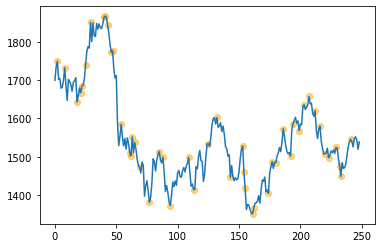

In [10]:
resampled_data.reset_index()['Close'].plot()
plt.scatter(minmax.index,minmax.values,color='orange',alpha=.5)

In [5]:
from collections import defaultdict

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns

In [6]:
patterns = find_patterns(minmax)
patterns

defaultdict(list, {'IHS': [(345, 370), (533, 559), (904, 943)]})

In [45]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-01-28,5.145158,5.146136,5.081565,5.107980,9394400,0.0,0.0
2013-01-29,5.123634,5.148092,5.089391,5.131461,8425600,0.0,0.0
2013-01-30,5.145158,5.191140,5.120699,5.168638,13819200,0.0,0.0
2013-01-31,5.118742,5.173530,5.107002,5.157876,15996800,0.0,0.0
2013-02-01,5.135375,5.171574,5.106024,5.167660,13364800,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-23,18.910000,19.110001,18.820000,19.049999,4319100,0.0,0.0
2023-01-24,18.969999,19.000000,18.840000,18.900000,7045600,0.0,0.0
2023-01-25,18.730000,18.740000,18.540001,18.620001,8245400,0.0,0.0


In [2]:
close =  df['Close']
high = df['High']
low = df['Low']
date= df['Date']

KeyError: 'Date'

In [4]:
cs = -1
cr = -1
flag = 0


buy = []
sell = []
total = 0 
support = []
resistance=[]

for i in range(0,df.shape[0]):
    if i<5 :
        continue
    
    a = low[i-4]
    b = low[i-3]
    c = low[i-2]
    d = low[i-1]
    e = low[i]
    
    a2 = high[i-4]
    b2 = high[i-3]
    c2 = high[i-2]
    d2 = high[i-1]
    e2 = high[i]
    
    
    if a2<b2 and b2<c2 and c2>d2 and d2>e2:
        cr=c2
    elif a>b and b>c and c<d and d<e:
        cs=c
        
    resistance.append(cr) 
    support.append(cs)
    
    
    if cs ==-1 or cr==-1:
        continue
    if close[i] > cr and flag==0:
        flag =1
        bp = close[i]
        buy.append(i)
        #print(cr)
    elif close[i] < cs and flag ==1:
        flag = 0
        sp = close[i]
        sell.append(i)
        total += sp-bp
if flag==1:
    total+= close[-1]-bp
print(total)

195.34695434570312


In [10]:

resistance[88]

18.989999771118164


4.41331451197121

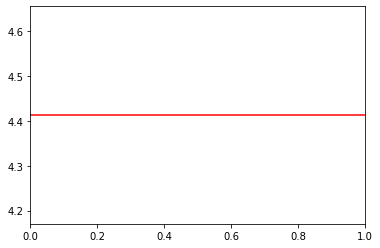

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

dfpl = df[60:100]
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])
plt.axhline(y = resistance[88], color = 'r', linestyle = '-')
fig.show()

In [27]:
df.shape[0]

2519

In [28]:
close[2]

5.168638229370117